# BI-RRT*

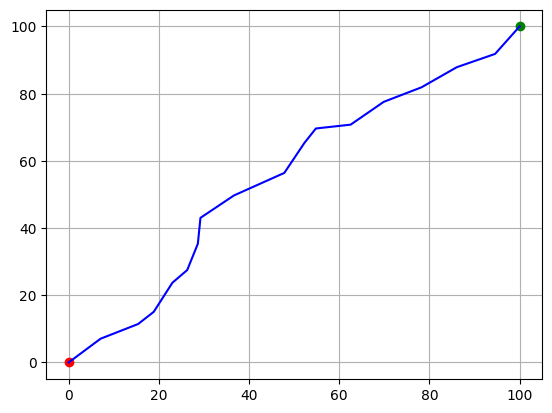

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0  # Initialize the cost attribute

class BiRRTStar:
    def __init__(self, start, goal, obstacles, max_iter=500, step_size=5, goal_sample_rate=0.1, search_radius=10):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacles = obstacles
        self.max_iter = max_iter
        self.step_size = step_size
        self.goal_sample_rate = goal_sample_rate
        self.search_radius = search_radius
        self.start_tree = [self.start]
        self.goal_tree = [self.goal]

    def plan(self):
        for _ in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_node_start = self.get_nearest_node(self.start_tree, rnd_node)
            new_node_start = self.steer(nearest_node_start, rnd_node)

            if self.is_collision_free(nearest_node_start, new_node_start):
                new_node_start.cost = nearest_node_start.cost + self.distance(nearest_node_start, new_node_start)
                self.start_tree.append(new_node_start)
                self.rewire(self.start_tree, new_node_start)
                
                nearest_node_goal = self.get_nearest_node(self.goal_tree, new_node_start)
                new_node_goal = self.steer(nearest_node_goal, new_node_start)

                if self.is_collision_free(nearest_node_goal, new_node_goal):
                    new_node_goal.cost = nearest_node_goal.cost + self.distance(nearest_node_goal, new_node_goal)
                    self.goal_tree.append(new_node_goal)
                    self.rewire(self.goal_tree, new_node_goal)
                    
                    if self.distance(new_node_start, new_node_goal) < self.step_size:
                        return self.generate_final_course(new_node_start, new_node_goal)

            # Swap start and goal trees
            self.start_tree, self.goal_tree = self.goal_tree, self.start_tree

        return None  # Path not found

    def get_random_node(self):
        if np.random.rand() > self.goal_sample_rate:
            return Node(np.random.rand() * 100, np.random.rand() * 100)
        else:
            return self.goal

    def get_nearest_node(self, tree, node):
        return min(tree, key=lambda n: self.distance(n, node))

    def steer(self, from_node, to_node):
        new_node = Node(from_node.x, from_node.y)
        d, theta = self.distance_and_angle(from_node, to_node)
        new_node.x += self.step_size * np.cos(theta)
        new_node.y += self.step_size * np.sin(theta)
        new_node.parent = from_node
        return new_node

    def is_collision_free(self, from_node, to_node):
        # Simple collision detection
        for obs in self.obstacles:
            if self.check_collision(from_node, to_node, obs):
                return False
        return True

    def check_collision(self, from_node, to_node, obs):
        # Implement actual collision detection here
        return False

    def rewire(self, tree, new_node):
        for node in tree:
            if self.distance(node, new_node) < self.search_radius:
                potential_cost = node.cost + self.distance(node, new_node)
                if self.is_collision_free(node, new_node) and potential_cost < new_node.cost:
                    new_node.parent = node
                    new_node.cost = potential_cost

    def distance_and_angle(self, from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        return np.hypot(dx, dy), np.arctan2(dy, dx)

    def distance(self, node1, node2):
        return np.hypot(node1.x - node2.x, node1.y - node2.y)

    def generate_final_course(self, node_start, node_goal):
        path = [(node_goal.x, node_goal.y)]
        node = node_goal
        while node.parent is not None:
            node = node.parent
            path.append((node.x, node.y))
        
        path.reverse()
        
        node = node_start
        while node.parent is not None:
            node = node.parent
            path.append((node.x, node.y))
        
        return path

# Example usage:
start = [0, 0]
goal = [100, 100]
obstacles = []  # Add obstacles if needed
birrt_star = BiRRTStar(start, goal, obstacles)
path = birrt_star.plan()

# Plotting the result
if path:
    plt.figure()
    for obs in obstacles:
        plt.plot(obs[0], obs[1], 'k')
    plt.plot(start[0], start[1], 'ro')
    plt.plot(goal[0], goal[1], 'go')
    plt.plot([x for (x, y) in path], [y for (x, y) in path], '-b')
    plt.grid(True)
    plt.show()
else:
    print("Path not found!")


# Informed RRT*

Start Informed RRT* planning
Found path!!


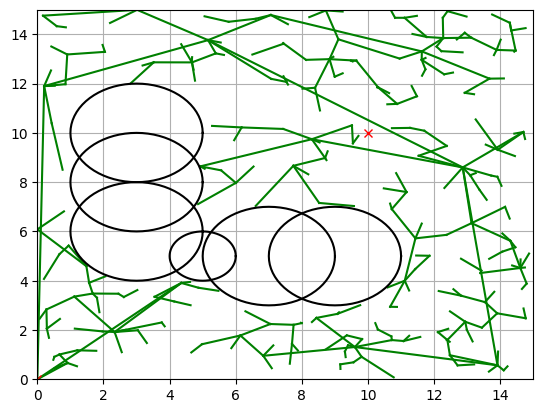

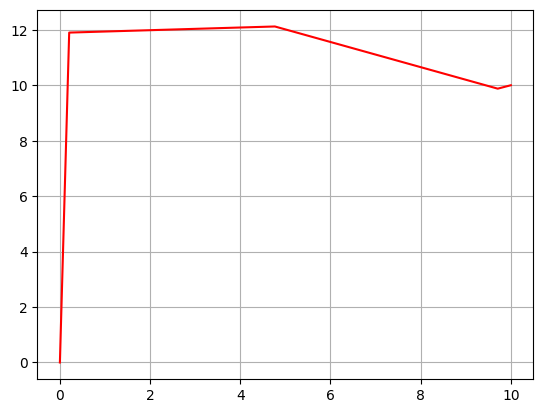

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.cost = 0.0
        self.parent = None

class InformedRRTStar:
    def __init__(self, start, goal, obstacle_list, rand_area, max_iter=500):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.obstacle_list = obstacle_list
        self.max_iter = max_iter
        self.node_list = [self.start]
    
    def get_random_node(self, c_best):
        c_min = np.linalg.norm([self.start.x - self.end.x, self.start.y - self.end.y])
        if c_best < float('inf') and c_best > c_min:
            x_center = np.array([(self.start.x + self.end.x) / 2.0, (self.start.y + self.end.y) / 2.0])
            a1 = np.array([[(self.end.x - self.start.x) / c_min, (self.end.y - self.start.y) / c_min]]).T
            etheta = math.atan2(self.end.y - self.start.y, self.end.x - self.start.x)
            rot = np.array([[math.cos(etheta), -math.sin(etheta)], [math.sin(etheta), math.cos(etheta)]])
            L = np.diag([c_best / 2.0, math.sqrt(c_best**2 - c_min**2) / 2.0])
            sample = self.sample_unit_ball()
            rnd = np.dot(rot, np.dot(L, sample)) + x_center
            return Node(rnd[0], rnd[1])
        else:
            rnd = [random.uniform(self.min_rand, self.max_rand), random.uniform(self.min_rand, self.max_rand)]
            return Node(rnd[0], rnd[1])

    def sample_unit_ball(self):
        a = random.random()
        b = random.random()
        if b < a:
            a, b = b, a
        sample = [b * math.cos(2 * math.pi * a / b), b * math.sin(2 * math.pi * a / b)]
        return np.array(sample)
    
    def planning(self):
        for i in range(self.max_iter):
            c_best = self.get_best_cost()
            rnd_node = self.get_random_node(c_best)
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]
            new_node = self.steer(nearest_node, rnd_node)
            
            if self.collision_check(new_node, self.obstacle_list):
                near_indices = self.find_near_nodes(new_node)
                new_node = self.choose_parent(new_node, near_indices)
                self.node_list.append(new_node)
                self.rewire(new_node, near_indices)

            if self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y) <= 0.5:
                final_node = self.steer(self.node_list[-1], self.end)
                if self.collision_check(final_node, self.obstacle_list):
                    return self.generate_final_course(len(self.node_list) - 1)

        return None

    def choose_parent(self, new_node, near_indices):
        if not near_indices:
            return new_node

        costs = []
        for i in near_indices:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.collision_check(t_node, self.obstacle_list):
                costs.append(near_node.cost + self.calc_dist(near_node, new_node))
            else:
                costs.append(float('inf'))

        min_cost = min(costs)
        min_ind = near_indices[costs.index(min_cost)]

        if min_cost == float('inf'):
            return new_node

        new_node.cost = min_cost
        new_node.parent = self.node_list[min_ind]

        return new_node

    def steer(self, from_node, to_node, extend_length=float("inf")):
        new_node = Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)
        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length)

        for _ in range(n_expand):
            new_node.x += math.cos(theta)
            new_node.y += math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= 1.0:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def get_best_cost(self):
        return min([node.cost + self.calc_dist_to_goal(node.x, node.y) for node in self.node_list])

    def calc_dist_to_goal(self, x, y):
        return np.linalg.norm([x - self.end.x, y - self.end.y])

    def get_nearest_node_index(self, node_list, rnd_node):
        dlist = [np.linalg.norm([node.x - rnd_node.x, node.y - rnd_node.y]) for node in node_list]
        minind = dlist.index(min(dlist))
        return minind

    def find_near_nodes(self, new_node):
        nnode = len(self.node_list)
        r = 50.0 * math.sqrt((math.log(nnode) / nnode))
        dlist = [np.linalg.norm([node.x - new_node.x, node.y - new_node.y]) for node in self.node_list]
        near_inds = [dlist.index(i) for i in dlist if i <= r]
        return near_inds

    def rewire(self, new_node, near_indices):
        for i in near_indices:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue

            edge_node.cost = new_node.cost + self.calc_dist(new_node, near_node)

            if self.collision_check(edge_node, self.obstacle_list) and near_node.cost > edge_node.cost:
                near_node.x = edge_node.x
                near_node.y = edge_node.y
                near_node.cost = edge_node.cost
                near_node.parent = new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])
        return path

    def calc_distance_and_angle(self, from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.sqrt(dx ** 2 + dy ** 2)
        theta = math.atan2(dy, dx)
        return d, theta

    def calc_dist(self, node1, node2):
        return np.linalg.norm([node1.x - node2.x, node1.y - node2.y])

    def collision_check(self, node, obstacle_list):
        if node is None:
            return False

        for (ox, oy, size) in obstacle_list:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= size**2:
                return False

        return True

    def draw_graph(self, rnd=None):
        plt.clf()
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([self.min_rand, self.max_rand, self.min_rand, self.max_rand])
        plt.grid(True)
        plt.pause(0.01)

    def plot_circle(self, x, y, size):
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, "-k")

def main():
    print("Start Informed RRT* planning")

    obstacle_list = [
        (5, 5, 1),
        (3, 6, 2),
        (3, 8, 2),
        (3, 10, 2),
        (7, 5, 2),
        (9, 5, 2)
    ]
    rand_area = [0, 15]

    rrt_star = InformedRRTStar(start=[0, 0], goal=[10, 10], obstacle_list=obstacle_list, rand_area=rand_area)
    path = rrt_star.planning()

    if path is None:
        print("No path found")
    else:
        print("Found path!!")

        if True:  # Displaying the final path
            rrt_star.draw_graph()
            plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
            plt.grid(True)
            plt.show()

if __name__ == '__main__':
    main()


# Advanced RRT*

Path found!


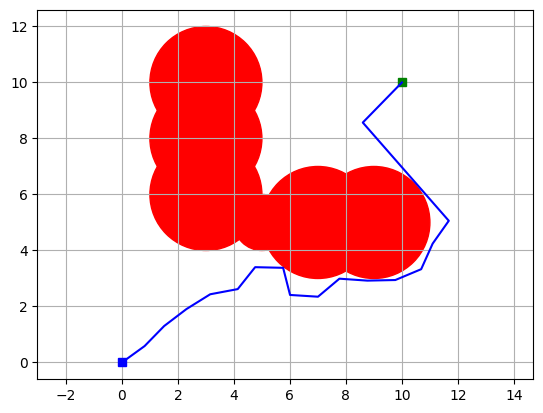

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

class BiRRTStar:
    def __init__(self, start, goal, obstacles, map_size, max_iter=1000, step_size=1.0, goal_sample_rate=5):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacles = obstacles
        self.map_size = map_size
        self.max_iter = max_iter
        self.step_size = step_size
        self.goal_sample_rate = goal_sample_rate
        self.start_tree = [self.start]
        self.goal_tree = [self.goal]
    
    def plan(self):
        for i in range(self.max_iter):
            if random.randint(0, 100) > self.goal_sample_rate:
                rnd_node = self.get_random_node()
            else:
                rnd_node = Node(self.goal.x, self.goal.y)
            
            nearest_node_start = self.get_nearest_node(self.start_tree, rnd_node)
            new_node_start = self.steer(nearest_node_start, rnd_node)

            if self.is_collision_free(new_node_start, nearest_node_start):
                self.start_tree.append(new_node_start)
                nearest_node_goal = self.get_nearest_node(self.goal_tree, new_node_start)
                new_node_goal = self.steer(nearest_node_goal, new_node_start)

                if self.is_collision_free(new_node_goal, nearest_node_goal):
                    self.goal_tree.append(new_node_goal)
                    if self.is_collision_free(new_node_goal, new_node_start):
                        return self.generate_final_path(new_node_start, new_node_goal)
        
        return None

    def steer(self, from_node, to_node):
        new_node = Node(from_node.x, from_node.y)
        dist = self.get_distance(from_node, to_node)
        angle = math.atan2(to_node.y - from_node.y, to_node.x - from_node.x)

        new_node.x += self.step_size * math.cos(angle)
        new_node.y += self.step_size * math.sin(angle)
        new_node.parent = from_node

        return new_node

    def get_random_node(self):
        return Node(random.uniform(0, self.map_size[0]), random.uniform(0, self.map_size[1]))

    def get_nearest_node(self, tree, node):
        return min(tree, key=lambda n: self.get_distance(n, node))

    def get_distance(self, node1, node2):
        return math.hypot(node1.x - node2.x, node1.y - node2.y)

    def is_collision_free(self, node1, node2):
        for ox, oy, size in self.obstacles:
            if self.line_intersects_circle(node1.x, node1.y, node2.x, node2.y, ox, oy, size):
                return False
        return True

    def line_intersects_circle(self, x1, y1, x2, y2, cx, cy, r):
        dx, dy = x2 - x1, y2 - y1
        fx, fy = x1 - cx, y1 - cy
        a = dx ** 2 + dy ** 2
        b = 2 * (fx * dx + fy * dy)
        c = (fx ** 2 + fy ** 2) - r ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return False
        
        discriminant = math.sqrt(discriminant)
        t1 = (-b - discriminant) / (2 * a)
        t2 = (-b + discriminant) / (2 * a)

        return 0 <= t1 <= 1 or 0 <= t2 <= 1

    def generate_final_path(self, start_node, goal_node):
        path = []
        node = start_node
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        path.reverse()
        
        node = goal_node.parent
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent

        return path

def main():
    start = (0, 0)
    goal = (10, 10)
    obstacles = [
        (5, 5, 1),
        (3, 6, 2),
        (3, 8, 2),
        (3, 10, 2),
        (7, 5, 2),
        (9, 5, 2)
    ]
    map_size = (60, 60)
    rrt_star = BiRRTStar(start, goal, obstacles, map_size)

    path = rrt_star.plan()

    if path is None:
        print("No path found!")
    else:
        print("Path found!")

        plt.figure()
        for ox, oy, size in obstacles:
            circle = plt.Circle((ox, oy), size, color='r')
            plt.gca().add_patch(circle)
        
        plt.plot(start[0], start[1], "bs")
        plt.plot(goal[0], goal[1], "gs")
        plt.plot([x for (x, y) in path], [y for (x, y) in path], 'b')
        plt.grid(True)
        plt.axis("equal")
        plt.show()

if __name__ == '__main__':
    main()


# BI-RRT

In [1]:
# Library Imports
import pygame
from random import randint as ri
pygame.init()
import time

# GAME Parameters
screen = pygame.display.set_mode([500, 550])
GAME_x = 20
GAME_y = 40
GAME_width = 440
GAME_height = 400
GAME_border = 3
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
custom_color_1 = (10, 145, 80)
screen.fill(WHITE)
INT_MAX = 100000000000000

# Class Definitions
class Button:
    def __init__(self, colour, x, y, width, height):
        self.colour = colour
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def create(self, screen):
        pygame.draw.rect(screen, self.colour, [self.x, self.y, self.width, self.height])

# Function Definition: Point inside Game?
def point_inside_game(x, y):
    if x > GAME_x + GAME_border and x < GAME_x + GAME_width - GAME_border:
        if y > GAME_y + GAME_border and y < GAME_y + GAME_height - GAME_border:
            return True
    return False

# Function Definition: Random Point Generator inside Game
def random_point():
    x_random = ri(GAME_x + GAME_border, GAME_x + GAME_width - GAME_border - 1)
    y_random = ri(GAME_y + GAME_border, GAME_y + GAME_height - GAME_border - 1)
    return (x_random, y_random)

# Function Definition: Point inside given Rectangle?
def point_inside_rec(xr, yr, wr, hr, x, y):
    if x > xr and x < xr + wr:
        if y > yr and y < yr + hr:
            return True
    return False

# Function Definition: Point to Point Distance
def p2p_dist(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)

# Function Definition: Text on Button
def ClickText():
    font = pygame.font.Font('freesansbold.ttf', 12)
    text = font.render('CLICK HERE', True, WHITE)
    textRect = text.get_rect()
    textRect.center = (75, 495)
    screen.blit(text, textRect)

# Function Definition: Description Text
def DesText(s, x = 315, y = 485):
    pygame.draw.rect(screen, WHITE, (125, 470, 500, 30))
    font = pygame.font.SysFont('segoeuisemilight', 15)
    text = font.render('%s' % (s), True, BLACK)
    textRect = text.get_rect()
    textRect.center = (x, y)
    screen.blit(text, textRect)

# Function Definition: RRT Algorithm
def RRT(x, y, parent):
    if (x, y) not in parent and screen.get_at((x, y)) != (0, 0, 0, 255):
        x_m, y_m = -1, -1
        cur_min = INT_MAX
        for v in parent:
            if p2p_dist(v, (x, y)) < cur_min:
                x_m, y_m = v
                cur_min = p2p_dist(v, (x, y))

        good = True
        ans = []
        if abs(x_m - x) < abs(y_m - y):
            if y_m < y:
                for u in range(y_m + 1, y + 1):
                    x_cur = int(((x_m - x) / (y_m - y)) * (u - y) + x)
                    y_cur = u
                    if screen.get_at((x_cur, y_cur)) == (0, 0, 0, 255):
                        good = False
                        break
                if good:
                    ans = [int(((x_m - x) / (y_m - y)) * (y_m + Step - y) + x), y_m + Step]
            else:
                for u in range(y, y_m):
                    x_cur = int(((x_m - x) / (y_m - y)) * (u - y) + x)
                    y_cur = u
                    if screen.get_at((x_cur, y_cur)) == (0, 0, 0, 255):
                        good = False
                        break
                if good:
                    ans = [int(((x_m - x) / (y_m - y)) * (y_m - Step - y) + x), y_m - Step]

        else:
            if x_m < x:
                for u in range(x_m + 1, x + 1):
                    x_cur = u
                    y_cur = int(((y_m - y) / (x_m - x)) * (u - x) + y)
                    if screen.get_at((x_cur, y_cur)) == (0, 0, 0, 255):
                        good = False
                        break
                if good:
                    ans = [x_m + Step, int(((y_m - y) / (x_m - x)) * (x_m + Step - x) + y)]
            else:
                for u in range(x, x_m):
                    x_cur = u
                    y_cur = int(((y_m - y) / (x_m - x)) * (u - x) + y)
                    if screen.get_at((x_cur, y_cur)) == (0, 0, 0, 255):
                        good = False
                        break
                if good:
                    ans = [x_m - Step, int(((y_m - y) / (x_m - x)) * (x_m - Step - x) + y)]
        return (good, x_m, y_m, ans)
    return (False, -1, -1, [])

def connect_trees(tree_a, tree_b):
    for x_a, y_a in tree_a:
        for x_b, y_b in tree_b:
            if p2p_dist((x_a, y_a), (x_b, y_b)) <= Step:
                return True, (x_a, y_a), (x_b, y_b)
    return False, None, None

running = True
# Button for Game
pygame.draw.rect(screen, BLACK, (GAME_x, GAME_y, GAME_width, GAME_height), GAME_border)
B1 = Button(BLACK, 25, 470, 100, 50)
B1.create(screen)
OBS = dict()

# Number of forward Steps towards random sampled point
Step = 10
# Start stores a single point [Starting point- RED Point]
Start = []

# End stores a set of destination point [Destination point- Green Point]
# Multiple points allowed to make the point appear bigger, and fast discovery,
# due to huge number of pixels in this game
End = set()

# parent stores the graph
parent_start = dict()
parent_goal = dict()
level = 1
ClickText()
DesText("Instruction :", y = 460)
DesText("Draw the Obstacles, then CLICK BLACK Button")
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            break
        if running == False:
            break
        m = pygame.mouse.get_pressed()
        x, y = pygame.mouse.get_pos()

        if m[0] == 1:
            if point_inside_rec(B1.x, B1.y, B1.width, B1.height, x, y):
                if level == 1 and Start == []:
                    level += 1
                    B1.colour = RED
                    DesText("Draw the Starting point, then CLICK RED Button")
                elif level == 2 and Start:
                    level += 1
                    B1.colour = GREEN
                    DesText("Draw the Destination point, then CLICK GREEN Button")
                elif level == 3 and End != set():
                    level += 1
                    B1.colour = BLUE
                    DesText("Path is being explored using BiRRT Algorithm")
                B1.create(screen)
                ClickText()
                continue
            elif level == 1:
                if point_inside_game(x, y):
                    OBS[(x, y)] = 1
                    pygame.draw.circle(screen, BLACK, (x, y), 10)
            elif level == 2 and Start == []:
                if point_inside_game(x, y):
                    Start = (x, y)
                    pygame.draw.circle(screen, RED, (x, y), 5)
            elif level == 3:
                if point_inside_game(x, y):
                    End.add((x, y))
                    pygame.draw.circle(screen, GREEN, (x, y), 10)

        if level >= 4:
            running = False
            break
    pygame.display.update()

running = True
parent_start[Start] = (-1, -1)
parent_goal = {(x, y): (-1, -1) for x, y in End}
Trace = []
Timer = time.time()

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            break

    x, y = random_point()
    if (time.time() - Timer) > 5:
        Step = 5

    good_start, x_m_start, y_m_start, ans_start = RRT(x, y, parent_start)
    if good_start and ans_start:
        x_cur_start = ans_start[0]
        y_cur_start = ans_start[1]
        if screen.get_at((x_cur_start, y_cur_start)) != (0, 0, 0, 255) and (x_cur_start, y_cur_start) not in parent_start:
            parent_start[(x_cur_start, y_cur_start)] = (x_m_start, y_m_start)
            pygame.draw.line(screen, BLUE, (x_cur_start, y_cur_start), (x_m_start, y_m_start), 2)

    x, y = random_point()
    good_goal, x_m_goal, y_m_goal, ans_goal = RRT(x, y, parent_goal)
    if good_goal and ans_goal:
        x_cur_goal = ans_goal[0]
        y_cur_goal = ans_goal[1]
        if screen.get_at((x_cur_goal, y_cur_goal)) != (0, 0, 0, 255) and (x_cur_goal, y_cur_goal) not in parent_goal:
            parent_goal[(x_cur_goal, y_cur_goal)] = (x_m_goal, y_m_goal)
            pygame.draw.line(screen, RED, (x_cur_goal, y_cur_goal), (x_m_goal, y_m_goal), 2)

    connected, node_start, node_goal = connect_trees(parent_start, parent_goal)
    if connected:
        Trace = node_start
        Trace_goal = node_goal
        running = False

    pygame.display.update()

running = True
# This loop gets the route back to Start point
while Trace and running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            break
    while Trace != Start:
        x, y = parent_start[Trace]
        pygame.draw.line(screen, GREEN, (x, y), Trace, 2)
        Trace = (x, y)
    DesText("Green Colored Path is the Required Path")
    pygame.display.update()

Trace = Trace_goal
while Trace and running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            break
    while Trace not in End:
        x, y = parent_goal[Trace]
        pygame.draw.line(screen, GREEN, (x, y), Trace, 2)
        Trace = (x, y)
    DesText("Green Colored Path is the Required Path")
    pygame.display.update()

# Quit the Game
pygame.quit()


pygame 2.6.0 (SDL 2.28.4, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


#Bi-RRT*

Path found!


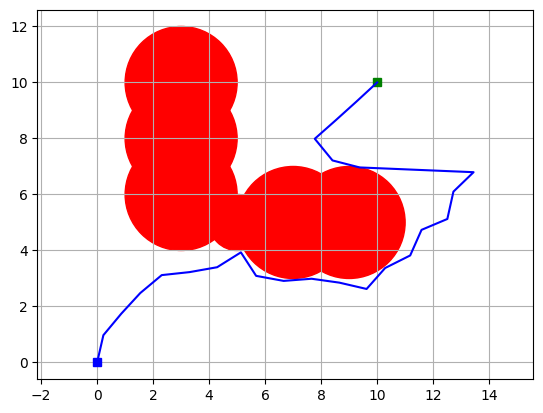

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Node class definition
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

# BiRRTStar class definition
class BiRRTStar:
    def __init__(self, start, goal, obstacles, map_size, max_iter=1000, step_size=1.0, goal_sample_rate=5):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacles = obstacles
        self.map_size = map_size
        self.max_iter = max_iter
        self.step_size = step_size
        self.goal_sample_rate = goal_sample_rate
        self.start_tree = [self.start]
        self.goal_tree = [self.goal]

# Initialize the parameters
start = (0, 0)
goal = (10, 10)
obstacles = [
    (5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (7, 5, 2),
    (9, 5, 2)
]
map_size = (60, 60)
rrt_star = BiRRTStar(start, goal, obstacles, map_size)

# Planning the path
path = None
for i in range(rrt_star.max_iter):
    if random.randint(0, 100) > rrt_star.goal_sample_rate:
        rnd_node = Node(random.uniform(0, rrt_star.map_size[0]), random.uniform(0, rrt_star.map_size[1]))
    else:
        rnd_node = Node(rrt_star.goal.x, rrt_star.goal.y)

    # Find the nearest node in the start tree
    nearest_node_start = rrt_star.start_tree[0]
    min_dist_start = math.hypot(nearest_node_start.x - rnd_node.x, nearest_node_start.y - rnd_node.y)
    for node in rrt_star.start_tree:
        dist = math.hypot(node.x - rnd_node.x, node.y - rnd_node.y)
        if dist < min_dist_start:
            nearest_node_start = node
            min_dist_start = dist

    # Steer towards the random node
    new_node_start = Node(nearest_node_start.x, nearest_node_start.y)
    dist = math.hypot(nearest_node_start.x - rnd_node.x, nearest_node_start.y - rnd_node.y)
    angle = math.atan2(rnd_node.y - nearest_node_start.y, rnd_node.x - nearest_node_start.x)
    new_node_start.x += rrt_star.step_size * math.cos(angle)
    new_node_start.y += rrt_star.step_size * math.sin(angle)
    new_node_start.parent = nearest_node_start

    # Collision checking for the new node in the start tree
    is_collision_free_start = True
    for ox, oy, size in rrt_star.obstacles:
        dx, dy = new_node_start.x - nearest_node_start.x, new_node_start.y - nearest_node_start.y
        fx, fy = nearest_node_start.x - ox, nearest_node_start.y - oy
        a = dx ** 2 + dy ** 2
        b = 2 * (fx * dx + fy * dy)
        c = (fx ** 2 + fy ** 2) - size ** 2
        discriminant = b ** 2 - 4 * a * c
        if discriminant >= 0:
            discriminant = math.sqrt(discriminant)
            t1 = (-b - discriminant) / (2 * a)
            t2 = (-b + discriminant) / (2 * a)
            if 0 <= t1 <= 1 or 0 <= t2 <= 1:
                is_collision_free_start = False
                break

    if is_collision_free_start:
        rrt_star.start_tree.append(new_node_start)

        # Find the nearest node in the goal tree
        nearest_node_goal = rrt_star.goal_tree[0]
        min_dist_goal = math.hypot(nearest_node_goal.x - new_node_start.x, nearest_node_goal.y - new_node_start.y)
        for node in rrt_star.goal_tree:
            dist = math.hypot(node.x - new_node_start.x, node.y - new_node_start.y)
            if dist < min_dist_goal:
                nearest_node_goal = node
                min_dist_goal = dist

        # Steer towards the new node from the start tree
        new_node_goal = Node(nearest_node_goal.x, nearest_node_goal.y)
        dist = math.hypot(nearest_node_goal.x - new_node_start.x, nearest_node_goal.y - new_node_start.y)
        angle = math.atan2(new_node_start.y - nearest_node_goal.y, new_node_start.x - nearest_node_goal.x)
        new_node_goal.x += rrt_star.step_size * math.cos(angle)
        new_node_goal.y += rrt_star.step_size * math.sin(angle)
        new_node_goal.parent = nearest_node_goal

        # Collision checking for the new node in the goal tree
        is_collision_free_goal = True
        for ox, oy, size in rrt_star.obstacles:
            dx, dy = new_node_goal.x - nearest_node_goal.x, new_node_goal.y - nearest_node_goal.y
            fx, fy = nearest_node_goal.x - ox, nearest_node_goal.y - oy
            a = dx ** 2 + dy ** 2
            b = 2 * (fx * dx + fy * dy)
            c = (fx ** 2 + fy ** 2) - size ** 2
            discriminant = b ** 2 - 4 * a * c
            if discriminant >= 0:
                discriminant = math.sqrt(discriminant)
                t1 = (-b - discriminant) / (2 * a)
                t2 = (-b + discriminant) / (2 * a)
                if 0 <= t1 <= 1 or 0 <= t2 <= 1:
                    is_collision_free_goal = False
                    break

        if is_collision_free_goal:
            rrt_star.goal_tree.append(new_node_goal)

            # Check if the trees have connected
            is_trees_connected = True
            for ox, oy, size in rrt_star.obstacles:
                dx, dy = new_node_goal.x - new_node_start.x, new_node_goal.y - new_node_start.y
                fx, fy = new_node_start.x - ox, new_node_start.y - oy
                a = dx ** 2 + dy ** 2
                b = 2 * (fx * dx + fy * dy)
                c = (fx ** 2 + fy ** 2) - size ** 2
                discriminant = b ** 2 - 4 * a * c
                if discriminant >= 0:
                    discriminant = math.sqrt(discriminant)
                    t1 = (-b - discriminant) / (2 * a)
                    t2 = (-b + discriminant) / (2 * a)
                    if 0 <= t1 <= 1 or 0 <= t2 <= 1:
                        is_trees_connected = False
                        break

            if is_trees_connected:
                path = []
                node = new_node_start
                while node is not None:
                    path.append((node.x, node.y))
                    node = node.parent
                path.reverse()

                node = new_node_goal.parent
                while node is not None:
                    path.append((node.x, node.y))
                    node = node.parent
                break

# Display the results
if path is None:
    print("No path found!")
else:
    print("Path found!")

    plt.figure()
    for ox, oy, size in obstacles:
        circle = plt.Circle((ox, oy), size, color='r')
        plt.gca().add_patch(circle)

    plt.plot(start[0], start[1], "bs")
    plt.plot(goal[0], goal[1], "gs")
    plt.plot([x for (x, y) in path], [y for (x, y) in path], 'b')
    plt.grid(True)
    plt.axis("equal")
    plt.show()


Path found!


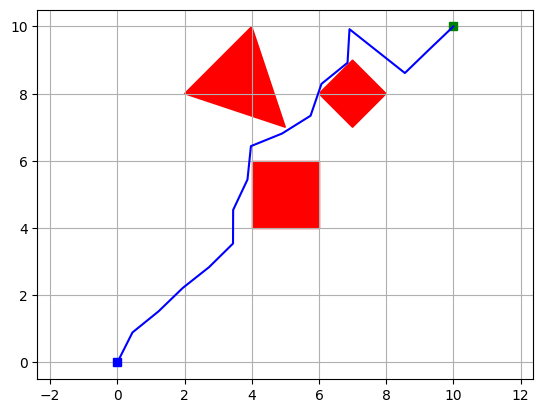

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from shapely.geometry import Point, Polygon, LineString

# Node class definition
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

# BiRRTStar class definition
class BiRRTStar:
    def __init__(self, start, goal, obstacles, map_size, max_iter=1000, step_size=1.0, goal_sample_rate=5):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacles = obstacles
        self.map_size = map_size
        self.max_iter = max_iter
        self.step_size = step_size
        self.goal_sample_rate = goal_sample_rate
        self.start_tree = [self.start]
        self.goal_tree = [self.goal]

# Initialize the parameters
start = (0, 0)
goal = (10, 10)
obstacles = [
    [(4, 4), (6, 4), (6, 6), (4, 6)],   # Square obstacle
    [(2, 8), (5, 7), (4, 10)],           # Triangular obstacle
    [(7, 7), (8, 8), (7, 9), (6, 8)]     # Diamond-shaped obstacle
]
map_size = (60, 60)
rrt_star = BiRRTStar(start, goal, obstacles, map_size)

# Planning the path
path = None
for i in range(rrt_star.max_iter):
    if random.randint(0, 100) > rrt_star.goal_sample_rate:
        rnd_node = Node(random.uniform(0, rrt_star.map_size[0]), random.uniform(0, rrt_star.map_size[1]))
    else:
        rnd_node = Node(rrt_star.goal.x, rrt_star.goal.y)

    # Find the nearest node in the start tree
    nearest_node_start = rrt_star.start_tree[0]
    min_dist_start = math.hypot(nearest_node_start.x - rnd_node.x, nearest_node_start.y - rnd_node.y)
    for node in rrt_star.start_tree:
        dist = math.hypot(node.x - rnd_node.x, node.y - rnd_node.y)
        if dist < min_dist_start:
            nearest_node_start = node
            min_dist_start = dist

    # Steer towards the random node
    new_node_start = Node(nearest_node_start.x, nearest_node_start.y)
    dist = math.hypot(nearest_node_start.x - rnd_node.x, nearest_node_start.y - rnd_node.y)
    angle = math.atan2(rnd_node.y - nearest_node_start.y, rnd_node.x - nearest_node_start.x)
    new_node_start.x += rrt_star.step_size * math.cos(angle)
    new_node_start.y += rrt_star.step_size * math.sin(angle)
    new_node_start.parent = nearest_node_start

    # Collision checking for the new node in the start tree
    is_collision_free_start = True
    for obstacle_points in rrt_star.obstacles:
        obstacle_polygon = Polygon(obstacle_points)
        line = LineString([(nearest_node_start.x, nearest_node_start.y), (new_node_start.x, new_node_start.y)])
        if line.intersects(obstacle_polygon):
            is_collision_free_start = False
            break

    if is_collision_free_start:
        rrt_star.start_tree.append(new_node_start)

        # Find the nearest node in the goal tree
        nearest_node_goal = rrt_star.goal_tree[0]
        min_dist_goal = math.hypot(nearest_node_goal.x - new_node_start.x, nearest_node_goal.y - new_node_start.y)
        for node in rrt_star.goal_tree:
            dist = math.hypot(node.x - new_node_start.x, node.y - new_node_start.y)
            if dist < min_dist_goal:
                nearest_node_goal = node
                min_dist_goal = dist

        # Steer towards the new node from the start tree
        new_node_goal = Node(nearest_node_goal.x, nearest_node_goal.y)
        dist = math.hypot(nearest_node_goal.x - new_node_start.x, nearest_node_goal.y - new_node_start.y)
        angle = math.atan2(new_node_start.y - nearest_node_goal.y, new_node_start.x - nearest_node_goal.x)
        new_node_goal.x += rrt_star.step_size * math.cos(angle)
        new_node_goal.y += rrt_star.step_size * math.sin(angle)
        new_node_goal.parent = nearest_node_goal

        # Collision checking for the new node in the goal tree
        is_collision_free_goal = True
        for obstacle_points in rrt_star.obstacles:
            obstacle_polygon = Polygon(obstacle_points)
            line = LineString([(nearest_node_goal.x, nearest_node_goal.y), (new_node_goal.x, new_node_goal.y)])
            if line.intersects(obstacle_polygon):
                is_collision_free_goal = False
                break

        if is_collision_free_goal:
            rrt_star.goal_tree.append(new_node_goal)

            # Check if the trees have connected
            is_trees_connected = True
            for obstacle_points in rrt_star.obstacles:
                obstacle_polygon = Polygon(obstacle_points)
                line = LineString([(new_node_goal.x, new_node_goal.y), (new_node_start.x, new_node_start.y)])
                if line.intersects(obstacle_polygon):
                    is_trees_connected = False
                    break

            if is_trees_connected:
                path = []
                node = new_node_start
                while node is not None:
                    path.append((node.x, node.y))
                    node = node.parent
                path.reverse()

                node = new_node_goal.parent
                while node is not None:
                    path.append((node.x, node.y))
                    node = node.parent
                break

# Display the results
if path is None:
    print("No path found!")
else:
    print("Path found!")

    plt.figure()
    for obstacle_points in obstacles:
        obstacle_polygon = Polygon(obstacle_points)
        x, y = obstacle_polygon.exterior.xy
        plt.fill(x, y, color='r')

    plt.plot(start[0], start[1], "bs")
    plt.plot(goal[0], goal[1], "gs")
    plt.plot([x for (x, y) in path], [y for (x, y) in path], 'b')
    plt.grid(True)
    plt.axis("equal")
    plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from shapely.geometry import Point, Polygon, LineString

# Initialize parameters
start_x, start_y = 0, 0
goal_x, goal_y = 25, 25
obstacles = [
    (8, 20, 2),   # Circle obstacle with center (8, 12) and radius 6
    (22, 7, 4),  # Circle obstacle with center (22, 20) and radius 3
    (15, 15, 3 ),  # Circle obstacle with center (15, 15) and radius 8
    [(18, 22), (25, 22), (25, 20), (18, 20)],  # Rectangle obstacle
    [(12, 5), (14, 5), (14, 7), (12, 7)]    # Irregular polygon obstacle
]    
map_size_x, map_size_y = 30, 30
max_iter = 1000
step_size = 1.0
goal_sample_rate = 5

start_tree = [(start_x, start_y, None)]
goal_tree = [(goal_x, goal_y, None)]

path = None
for i in range(max_iter):
    # Randomly sample a point or choose the goal with a certain probability
    if random.randint(0, 100) > goal_sample_rate:
        rnd_x, rnd_y = random.uniform(0, map_size_x), random.uniform(0, map_size_y)
    else:
        rnd_x, rnd_y = goal_x, goal_y

    # Find the nearest node in the start tree
    nearest_node_start = start_tree[0]
    min_dist_start = math.hypot(nearest_node_start[0] - rnd_x, nearest_node_start[1] - rnd_y)
    for node in start_tree:
        dist = math.hypot(node[0] - rnd_x, node[1] - rnd_y)
        if dist < min_dist_start:
            nearest_node_start = node
            min_dist_start = dist

    # Steer towards the random node from the nearest node in the start tree
    new_x_start, new_y_start = nearest_node_start[0], nearest_node_start[1]
    angle = math.atan2(rnd_y - nearest_node_start[1], rnd_x - nearest_node_start[0])
    new_x_start += step_size * math.cos(angle)
    new_y_start += step_size * math.sin(angle)
    new_node_start = (new_x_start, new_y_start, nearest_node_start)

    # Collision checking for the new node in the start tree
        #print(oy)
    is_collision_free_start = True
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            for obstacle in obstacles:
                for i in range(0,15):
                    oy=oy+1
            ox, oy, radius = obstacle
            line = LineString([(nearest_node_start[0], nearest_node_start[1]), (new_x_start, new_y_start)])
            if line.distance(Point(ox, oy)) <= radius:
                is_collision_free_start = False
                break
        elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
            obstacle_polygon = Polygon(obstacle)
            line = LineString([(nearest_node_start[0], nearest_node_start[1]), (new_x_start, new_y_start)])
            if line.intersects(obstacle_polygon):
                is_collision_free_start = False
                break

    if is_collision_free_start:
        start_tree.append(new_node_start)

        # Find the nearest node in the goal tree
        nearest_node_goal = goal_tree[0]
        min_dist_goal = math.hypot(nearest_node_goal[0] - new_x_start, nearest_node_goal[1] - new_y_start)
        for node in goal_tree:
            dist = math.hypot(node[0] - new_x_start, node[1] - new_y_start)
            if dist < min_dist_goal:
                nearest_node_goal = node
                min_dist_goal = dist

        # Steer towards the new node from the start tree
        new_x_goal, new_y_goal = nearest_node_goal[0], nearest_node_goal[1]
        angle = math.atan2(new_y_start - nearest_node_goal[1], new_x_start - nearest_node_goal[0])
        new_x_goal += step_size * math.cos(angle)
        new_y_goal += step_size * math.sin(angle)
        new_node_goal = (new_x_goal, new_y_goal, nearest_node_goal)

        # Collision checking for the new node in the goal tree
        is_collision_free_goal = True
        for obstacle in obstacles:
            if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
                ox, oy, radius = obstacle
                line = LineString([(nearest_node_goal[0], nearest_node_goal[1]), (new_x_goal, new_y_goal)])
                if line.distance(Point(ox, oy)) <= radius:
                    is_collision_free_goal = False
                    break
            elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
                obstacle_polygon = Polygon(obstacle)
                line = LineString([(nearest_node_goal[0], nearest_node_goal[1]), (new_x_goal, new_y_goal)])
                if line.intersects(obstacle_polygon):
                    is_collision_free_goal = False
                    break

        if is_collision_free_goal:
            goal_tree.append(new_node_goal)

            # Check if the trees have connected
            is_trees_connected = True
            for obstacle in obstacles:
                if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
                    ox, oy, radius = obstacle
                    line = LineString([(new_x_goal, new_y_goal), (new_x_start, new_y_start)])
                    if line.distance(Point(ox, oy)) <= radius:
                        is_trees_connected = False
                        break
                elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
                    obstacle_polygon = Polygon(obstacle)
                    line = LineString([(new_x_goal, new_y_goal), (new_x_start, new_y_start)])
                    if line.intersects(obstacle_polygon):
                        is_trees_connected = False
                        break

            if is_trees_connected:
                path = []
                node = new_node_start
                while node is not None:
                    path.append((node[0], node[1]))
                    node = node[2]
                path.reverse()

                node = new_node_goal[2]
                while node is not None:
                    path.append((node[0], node[1]))
                    node = node[2]
                break

# Display the results
if path is None:
    print("No path found!")
else:
    print("Path found!")
    plt.figure()
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            print(oy)
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='r', alpha=0.5)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.fill(x, y, color='r', alpha=0.5)

    plt.plot(start_x, start_y, "bs")
    plt.plot(goal_x, goal_y, "gs")
    plt.plot([x for (x, y) in path], [y for (x, y) in path], 'b')
    plt.grid(True)
    plt.axis("equal")
    plt.show()


ValueError: too many values to unpack (expected 3)

Path found!


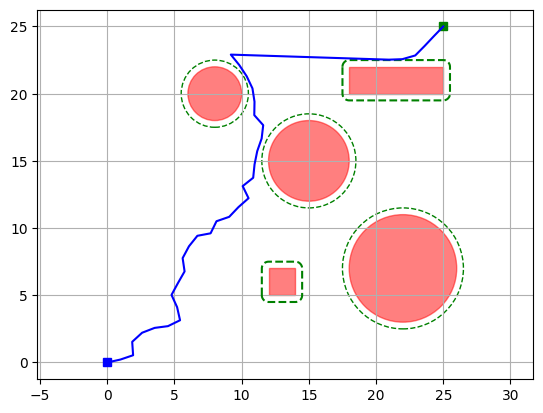

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from shapely.geometry import Point, Polygon, LineString
start_x, start_y = 0, 0
goal_x, goal_y = 25, 25
bonus_boundary = 0.5
#Obstacles
original_obstacles = [
    (8, 20, 2),   # Circle obstacle with center (8, 20) and radius 2
    (22, 7, 4),   # Circle obstacle with center (22, 7) and radius 4
    (15, 15, 3),  # Circle obstacle with center (15, 15) and radius 3
    [(18, 22), (25, 22), (25, 20), (18, 20)],  # Rectangle obstacle
    [(12, 5), (14, 5), (14, 7), (12, 7)]       # Rectangle obstacle
]
#Adding the bonus boundary
effective_obstacles = []
for obstacle in original_obstacles:
    if isinstance(obstacle, tuple) and len(obstacle) == 3:  
        ox, oy, radius = obstacle
        effective_obstacles.append((ox, oy, radius + bonus_boundary))
    elif isinstance(obstacle, list):  
        obstacle_polygon = Polygon(obstacle)
        enlarged_polygon = obstacle_polygon.buffer(bonus_boundary)  
        effective_obstacles.append(list(enlarged_polygon.exterior.coords))
map_size_x, map_size_y = 30, 30
max_iter = 1000
step_size = 1.0
goal_sample_rate = 5

start_tree = [(start_x, start_y, None)]
goal_tree = [(goal_x, goal_y, None)]

path = None
for i in range(max_iter):
    #Randomly sample a point or choose the goal
    if random.randint(0, 100) > goal_sample_rate:
        rnd_x, rnd_y = random.uniform(0, map_size_x), random.uniform(0, map_size_y)
    else:
        rnd_x, rnd_y = goal_x, goal_y
    #Finding the nearest node in the start tree
    nearest_node_start = start_tree[0]
    min_dist_start = math.hypot(nearest_node_start[0] - rnd_x, nearest_node_start[1] - rnd_y)
    for node in start_tree:
        dist = math.hypot(node[0] - rnd_x, node[1] - rnd_y)
        if dist < min_dist_start:
            nearest_node_start = node
            min_dist_start = dist
    new_x_start, new_y_start = nearest_node_start[0], nearest_node_start[1]
    angle = math.atan2(rnd_y - nearest_node_start[1], rnd_x - nearest_node_start[0])
    new_x_start += step_size * math.cos(angle)
    new_y_start += step_size * math.sin(angle)
    new_node_start = (new_x_start, new_y_start, nearest_node_start)
    is_collision_free_start = True
    for obstacle in effective_obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:
            ox, oy, radius = obstacle
            line = LineString([(nearest_node_start[0], nearest_node_start[1]), (new_x_start, new_y_start)])
            if line.distance(Point(ox, oy)) <= radius:
                is_collision_free_start = False
                break
        elif isinstance(obstacle, list): 
            obstacle_polygon = Polygon(obstacle)
            line = LineString([(nearest_node_start[0], nearest_node_start[1]), (new_x_start, new_y_start)])
            if line.intersects(obstacle_polygon):
                is_collision_free_start = False
                break

    if is_collision_free_start:
        start_tree.append(new_node_start)
        nearest_node_goal = goal_tree[0]
        min_dist_goal = math.hypot(nearest_node_goal[0] - new_x_start, nearest_node_goal[1] - new_y_start)
        for node in goal_tree:
            dist = math.hypot(node[0] - new_x_start, node[1] - new_y_start)
            if dist < min_dist_goal:
                nearest_node_goal = node
                min_dist_goal = dist
        new_x_goal, new_y_goal = nearest_node_goal[0], nearest_node_goal[1]
        angle = math.atan2(new_y_start - nearest_node_goal[1], new_x_start - nearest_node_goal[0])
        new_x_goal += step_size * math.cos(angle)
        new_y_goal += step_size * math.sin(angle)
        new_node_goal = (new_x_goal, new_y_goal, nearest_node_goal)
        is_collision_free_goal = True
        for obstacle in effective_obstacles:
            if isinstance(obstacle, tuple) and len(obstacle) == 3:  
                ox, oy, radius = obstacle
                line = LineString([(nearest_node_goal[0], nearest_node_goal[1]), (new_x_goal, new_y_goal)])
                if line.distance(Point(ox, oy)) <= radius:
                    is_collision_free_goal = False
                    break
            elif isinstance(obstacle, list):  
                obstacle_polygon = Polygon(obstacle)
                line = LineString([(nearest_node_goal[0], nearest_node_goal[1]), (new_x_goal, new_y_goal)])
                if line.intersects(obstacle_polygon):
                    is_collision_free_goal = False
                    break

        if is_collision_free_goal:
            goal_tree.append(new_node_goal)
            is_trees_connected = True
            for obstacle in effective_obstacles:
                if isinstance(obstacle, tuple) and len(obstacle) == 3:  
                    ox, oy, radius = obstacle
                    line = LineString([(new_x_goal, new_y_goal), (new_x_start, new_y_start)])
                    if line.distance(Point(ox, oy)) <= radius:
                        is_trees_connected = False
                        break
                elif isinstance(obstacle, list): 
                    obstacle_polygon = Polygon(obstacle)
                    line = LineString([(new_x_goal, new_y_goal), (new_x_start, new_y_start)])
                    if line.intersects(obstacle_polygon):
                        is_trees_connected = False
                        break
            if is_trees_connected:
                path = []
                node = new_node_start
                while node is not None:
                    path.append((node[0], node[1]))
                    node = node[2]
                path.reverse()
                node = new_node_goal[2]
                while node is not None:
                    path.append((node[0], node[1]))
                    node = node[2]
                break
# Display the results
if path is None:
    print("No path found!")
else:
    print("Path found!")
    plt.figure()

    # Draw original obstacles
    for obstacle in original_obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='r', alpha=0.5)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.fill(x, y, color='r', alpha=0.5)

    # Draw effective boundaries as dotted lines
    for obstacle in effective_obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='g', linestyle='--', fill=False)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.plot(x, y, 'g--')

    # Plot the path
    plt.plot(start_x, start_y, "bs")
    plt.plot(goal_x, goal_y, "gs")
    plt.plot([x for (x, y) in path], [y for (x, y) in path], 'b')
    plt.grid(True)
    plt.axis("equal")
    plt.show()


44.27 units
50.90 units


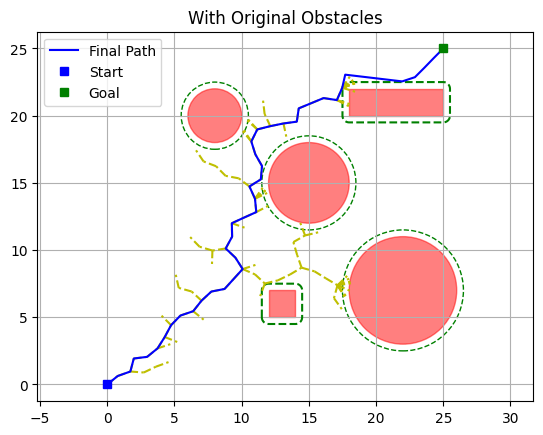

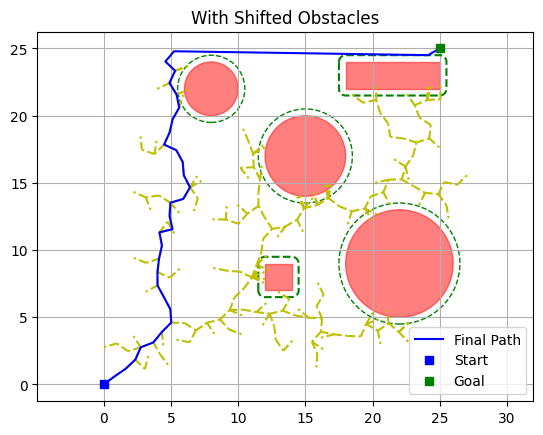

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from shapely.geometry import Point, Polygon, LineString
# Collision detection function
def is_collision_free(start, end, obstacles):
    line = LineString([start, end])
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3: 
            ox, oy, radius = obstacle
            if line.distance(Point(ox, oy)) <= radius:
                return False
        elif isinstance(obstacle, list): 
            obstacle_polygon = Polygon(obstacle)
            if line.intersects(obstacle_polygon):
                return False
    return True
# Calculating path distance
def calculate_path_distance(path):
    total_distance = 0.0
    for i in range(1, len(path)):
        x1, y1 = path[i - 1]
        x2, y2 = path[i]
        total_distance += math.hypot(x2 - x1, y2 - y1)
    return total_distance
# Bi-RRT* algorithm implementation
def bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles):
    map_size_x, map_size_y = 30, 30
    max_iter = 1000
    step_size = 1.0
    goal_sample_rate = 5
    start_tree = [(start_x, start_y, None)]
    goal_tree = [(goal_x, goal_y, None)]
    path = None
    all_paths = []
    for i in range(max_iter):
        if random.randint(0, 100) > goal_sample_rate:
            rnd_x, rnd_y = random.uniform(0, map_size_x), random.uniform(0, map_size_y)
        else:
            rnd_x, rnd_y = goal_x, goal_y
        nearest_node_start = min(start_tree, key=lambda node: math.hypot(node[0] - rnd_x, node[1] - rnd_y))
        new_x_start, new_y_start = nearest_node_start[0], nearest_node_start[1]
        angle = math.atan2(rnd_y - nearest_node_start[1], rnd_x - nearest_node_start[0])
        new_x_start += step_size * math.cos(angle)
        new_y_start += step_size * math.sin(angle)
        new_node_start = (new_x_start, new_y_start, nearest_node_start)
        if is_collision_free((nearest_node_start[0], nearest_node_start[1]), (new_x_start, new_y_start), effective_obstacles):
            start_tree.append(new_node_start)
            nearest_node_goal = min(goal_tree, key=lambda node: math.hypot(node[0] - new_x_start, node[1] - new_y_start))
            angle = math.atan2(new_y_start - nearest_node_goal[1], new_x_start - nearest_node_goal[0])
            new_x_goal = nearest_node_goal[0] + step_size * math.cos(angle)
            new_y_goal = nearest_node_goal[1] + step_size * math.sin(angle)
            new_node_goal = (new_x_goal, new_y_goal, nearest_node_goal)
            if is_collision_free((nearest_node_goal[0], nearest_node_goal[1]), (new_x_goal, new_y_goal), effective_obstacles):
                goal_tree.append(new_node_goal)
                if is_collision_free((new_x_goal, new_y_goal), (new_x_start, new_y_start), effective_obstacles):
                    path = []
                    node = new_node_start
                    while node is not None:
                        path.append((node[0], node[1]))
                        node = node[2]
                    path.reverse()
                    node = new_node_goal[2]
                    while node is not None:
                        path.append((node[0], node[1]))
                        node = node[2]
                    break
        if new_node_start[2] is not None:
            all_paths.append((new_node_start, new_node_start[2]))
    return path, all_paths
# Shift obstacles function
def shift_obstacles(obstacles, shift_x, shift_y):
    shifted_obstacles = []
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circular obstacle
            ox, oy, radius = obstacle
            shifted_obstacles.append((ox + shift_x, oy + shift_y, radius))
        elif isinstance(obstacle, list):  # Polygon obstacle
            shifted_obstacles.append([(x + shift_x, y + shift_y) for x, y in obstacle])
    return shifted_obstacles
# Adding the bonus boundary
def add_bonus_boundary(obstacles, bonus_boundary):
    effective_obstacles = []
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  
            ox, oy, radius = obstacle
            effective_obstacles.append((ox, oy, radius + bonus_boundary))
        elif isinstance(obstacle, list):  
            obstacle_polygon = Polygon(obstacle)
            enlarged_polygon = obstacle_polygon.buffer(bonus_boundary)
            effective_obstacles.append(list(enlarged_polygon.exterior.coords))
    return effective_obstacles
#Display of results
def display_results(obstacles, effective_obstacles, path, all_paths, distance, title):
    plt.figure()
    plt.title(f"{title}")
    print(f"{distance:.2f} units")
    # Draw original obstacles
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='r', alpha=0.5)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.fill(x, y, color='r', alpha=0.5)

    # Draw effective boundaries as dotted lines
    for obstacle in effective_obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='g', linestyle='--', fill=False)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.plot(x, y, 'g--')

    # Plot all intermediate paths
    for node, parent in all_paths:
        plt.plot([parent[0], node[0]], [parent[1], node[1]], 'y--')

    # Plot the final path
    if path:
        plt.plot([x for (x, y) in path], [y for (x, y) in path], 'b', label='Final Path')
  
    plt.plot(start_x, start_y, "bs", label="Start")
    plt.plot(goal_x, goal_y, "gs", label="Goal")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
# Initial parameters
start_x, start_y = 0, 0
goal_x, goal_y = 25, 25
bonus_boundary = 0.5
shift_x = 0  # Shift value for x
shift_y = 2  # Shift value for y
# Obstacles 
original_obstacles = [
    (8, 20, 2),   # Circle obstacle with center (8, 20) and radius 2
    (22, 7, 4),   # Circle obstacle with center (22, 7) and radius 4
    (15, 15, 3),  # Circle obstacle with center (15, 15) and radius 3
    [(18, 22), (25, 22), (25, 20), (18, 20)],  # Rectangle obstacle
    [(12, 5), (14, 5), (14, 7), (12, 7)]       # Rectangle obstacle
]
# Run Bi-RRT* for the original obstacles
effective_obstacles_original = add_bonus_boundary(original_obstacles, bonus_boundary)
path_original, all_paths_original = bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles_original)
distance_original = calculate_path_distance(path_original)
display_results(original_obstacles, effective_obstacles_original, path_original, all_paths_original, distance_original, "With Original Obstacles")
# Shift obstacles
shifted_obstacles = shift_obstacles(original_obstacles, shift_x, shift_y)
# Run Bi-RRT* for the shifted obstacles
effective_obstacles_shifted = add_bonus_boundary(shifted_obstacles, bonus_boundary)
path_shifted, all_paths_shifted = bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles_shifted)
distance_shifted = calculate_path_distance(path_shifted)
display_results(shifted_obstacles, effective_obstacles_shifted, path_shifted, all_paths_shifted, distance_shifted, "With Shifted Obstacles")
# Show both plots
plt.show()

42.34 units
44.65 units


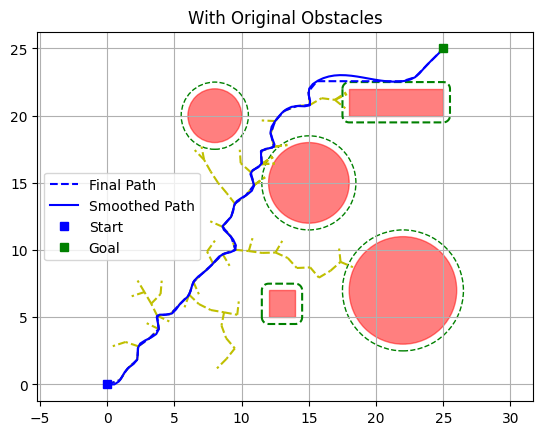

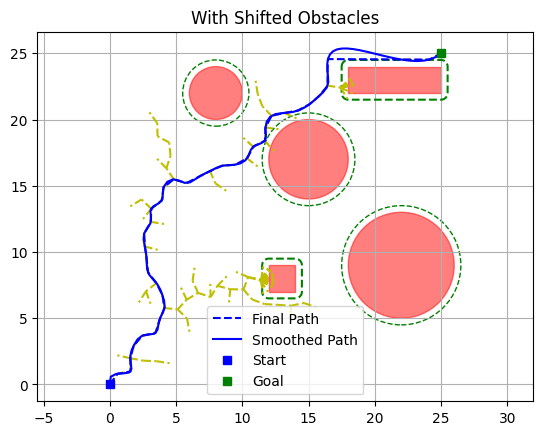

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from shapely.geometry import Point, Polygon, LineString
from scipy.interpolate import splev, splprep
# Collision detection function
def is_collision_free(start, end, obstacles):
    line = LineString([start, end])
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  
            ox, oy, radius = obstacle
            if line.distance(Point(ox, oy)) <= radius:
                return False
        elif isinstance(obstacle, list):  
            obstacle_polygon = Polygon(obstacle)
            if line.intersects(obstacle_polygon):
                return False
    return True
# Calculating path distance
def calculate_path_distance(path):
    total_distance = 0.0
    if path is None:
        return float('inf')
    for i in range(1, len(path)):
        x1, y1 = path[i - 1]
        x2, y2 = path[i]
        total_distance += math.hypot(x2 - x1, y2 - y1)
    return total_distance
# Bi-RRT* algorithm implementation
def bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles):
    map_size_x, map_size_y = 30, 30
    max_iter = 1000
    step_size = 1.0
    goal_sample_rate = 5
    start_tree = [(start_x, start_y, None)]
    goal_tree = [(goal_x, goal_y, None)]
    path = None
    all_paths = []
    for i in range(max_iter):
        if random.randint(0, 100) > goal_sample_rate:
            rnd_x, rnd_y = random.uniform(0, map_size_x), random.uniform(0, map_size_y)
        else:
            rnd_x, rnd_y = goal_x, goal_y
        nearest_node_start = min(start_tree, key=lambda node: math.hypot(node[0] - rnd_x, node[1] - rnd_y))
        new_x_start, new_y_start = nearest_node_start[0], nearest_node_start[1]
        angle = math.atan2(rnd_y - nearest_node_start[1], rnd_x - nearest_node_start[0])
        new_x_start += step_size * math.cos(angle)
        new_y_start += step_size * math.sin(angle)
        new_node_start = (new_x_start, new_y_start, nearest_node_start)
        if is_collision_free((nearest_node_start[0], nearest_node_start[1]), (new_x_start, new_y_start), effective_obstacles):
            start_tree.append(new_node_start)
            nearest_node_goal = min(goal_tree, key=lambda node: math.hypot(node[0] - new_x_start, node[1] - new_y_start))
            angle = math.atan2(new_y_start - nearest_node_goal[1], new_x_start - nearest_node_goal[0])
            new_x_goal = nearest_node_goal[0] + step_size * math.cos(angle)
            new_y_goal = nearest_node_goal[1] + step_size * math.sin(angle)
            new_node_goal = (new_x_goal, new_y_goal, nearest_node_goal)
            if is_collision_free((nearest_node_goal[0], nearest_node_goal[1]), (new_x_goal, new_y_goal), effective_obstacles):
                goal_tree.append(new_node_goal)

                # Check if trees can be connected
                if is_collision_free((new_x_goal, new_y_goal), (new_x_start, new_y_start), effective_obstacles):
                    # Build path from start to goal
                    path = []
                    node = new_node_start
                    while node is not None:
                        path.append((node[0], node[1]))
                        node = node[2]
                    path.reverse()
                    node = new_node_goal[2]
                    while node is not None:
                        path.append((node[0], node[1]))
                        node = node[2]
                    break

        # Store the intermediate path for later plotting
        if new_node_start[2] is not None:
            all_paths.append((new_node_start, new_node_start[2]))

    return path, all_paths
# Shift obstacles function
def shift_obstacles(obstacles, shift_x, shift_y):
    shifted_obstacles = []
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circular obstacle
            ox, oy, radius = obstacle
            shifted_obstacles.append((ox + shift_x, oy + shift_y, radius))
        elif isinstance(obstacle, list):  # Polygon obstacle
            shifted_obstacles.append([(x + shift_x, y + shift_y) for x, y in obstacle])
    return shifted_obstacles
# Adding the bonus boundary
def add_bonus_boundary(obstacles, bonus_boundary):
    effective_obstacles = []
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circular obstacle
            ox, oy, radius = obstacle
            effective_obstacles.append((ox, oy, radius + bonus_boundary))
        elif isinstance(obstacle, list):  # Polygon obstacle
            obstacle_polygon = Polygon(obstacle)
            enlarged_polygon = obstacle_polygon.buffer(bonus_boundary)
            effective_obstacles.append(list(enlarged_polygon.exterior.coords))
    return effective_obstacles
# Smooth path using B-spline
def smooth_path_b_spline(path, smoothing_factor=0):
    
    x, y = zip(*path)
    tck, u = splprep([x, y], s=smoothing_factor, k=3)
    u_fine = np.linspace(0, 1, num=100)
    x_fine, y_fine = splev(u_fine, tck)
    return list(zip(x_fine, y_fine))
# Display results function
def display_results(obstacles, effective_obstacles, path, smooth_path, all_paths, distance, title):
    plt.figure()
    plt.title(f"{title}")
    print(f"{distance:.2f} units")

    # Draw original obstacles
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='r', alpha=0.5)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.fill(x, y, color='r', alpha=0.5)

    # Draw effective boundaries as dotted lines
    for obstacle in effective_obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='g', linestyle='--', fill=False)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  # Rectangle (Polygon) obstacle
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.plot(x, y, 'g--')

    # Plot all intermediate paths
    for node, parent in all_paths:
        plt.plot([parent[0], node[0]], [parent[1], node[1]], 'y--')

    # Plot the final path
    if path:
        plt.plot([x for (x, y) in path], [y for (x, y) in path], 'b--', label='Final Path')

    # Plot the smoothed path
    if smooth_path:
        plt.plot([x for (x, y) in smooth_path], [y for (x, y) in smooth_path], 'b', label='Smoothed Path')
  
    plt.plot(start_x, start_y, "bs", label="Start")
    plt.plot(goal_x, goal_y, "gs", label="Goal")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
# Initial parameters
start_x, start_y = 0, 0
goal_x, goal_y = 250, 300
bonus_boundary = 0.5
shift_x = 0  # Shift value for x
shift_y = 2  # Shift value for y
# Obstacles definition
original_obstacles = [
    (8, 20, 2),   # Circle obstacle with center (8, 20) and radius 2
    (22, 7, 4),   # Circle obstacle with center (22, 7) and radius 4
    (15, 15, 3),  # Circle obstacle with center (15, 15) and radius 3
    [(18, 22), (25, 22), (25, 20), (18, 20)],  # Rectangle obstacle
    [(12, 5), (14, 5), (14, 7), (12, 7)]       # Rectangle obstacle
]
# Apply shift and bonus boundary
shifted_obstacles = shift_obstacles(original_obstacles, shift_x, shift_y)
effective_obstacles_original = add_bonus_boundary(original_obstacles, bonus_boundary)
effective_obstacles_shifted = add_bonus_boundary(shifted_obstacles, bonus_boundary)
# Find paths for both scenarios
path_original, all_paths_original = bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles_original)
path_shifted, all_paths_shifted = bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles_shifted)
# Smooth paths
smooth_path_original = smooth_path_b_spline(path_original)
smooth_path_shifted = smooth_path_b_spline(path_shifted)
# Calculate path distances
distance_original = calculate_path_distance(path_original) if path_original else float('inf')
distance_shifted = calculate_path_distance(path_shifted) if path_shifted else float('inf')
# Display results for original and shifted obstacles
display_results(original_obstacles, effective_obstacles_original, path_original, smooth_path_original, all_paths_original, distance_original, "With Original Obstacles")
display_results(shifted_obstacles, effective_obstacles_shifted, path_shifted, smooth_path_shifted, all_paths_shifted, distance_shifted, "With Shifted Obstacles")
plt.show()

Time step: 0
Path distance: 50.73 units


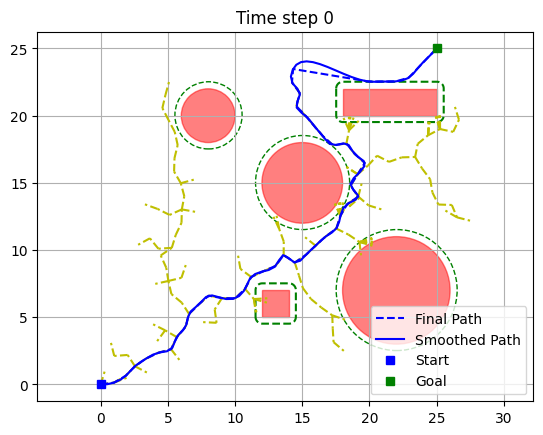

Time step: 1
Path distance: 47.73 units


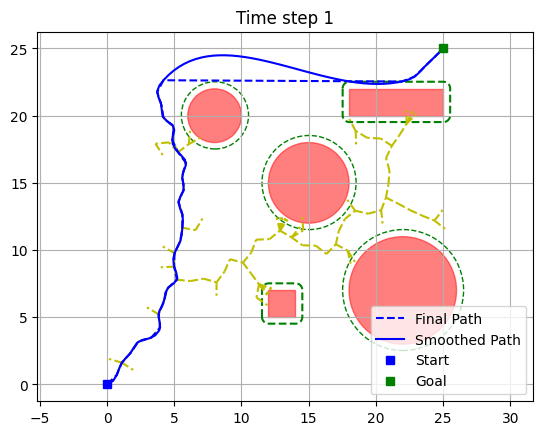

Time step: 2
Path distance: 49.11 units


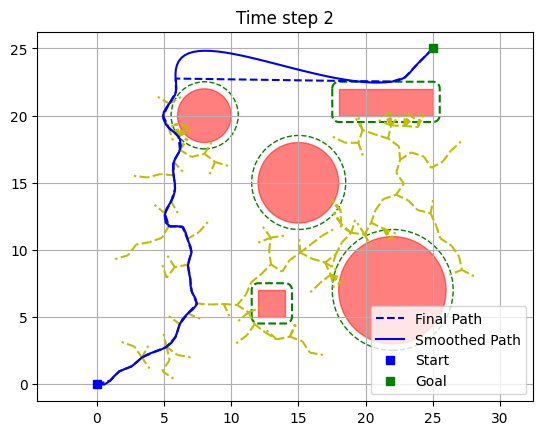

Time step: 3
Path distance: 45.43 units


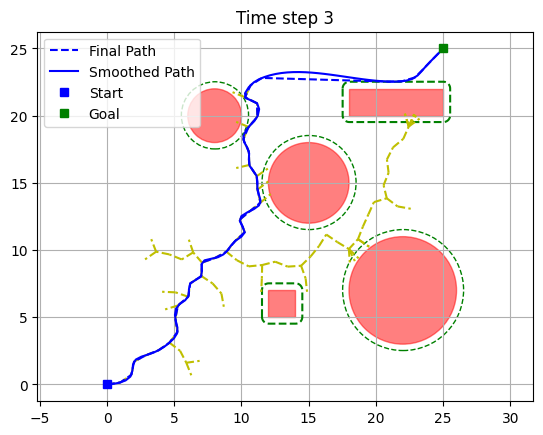

Time step: 4
Path distance: 63.58 units


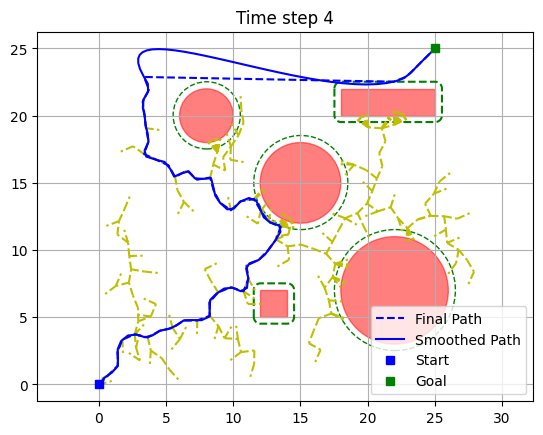

Time step: 5
Path distance: 43.06 units


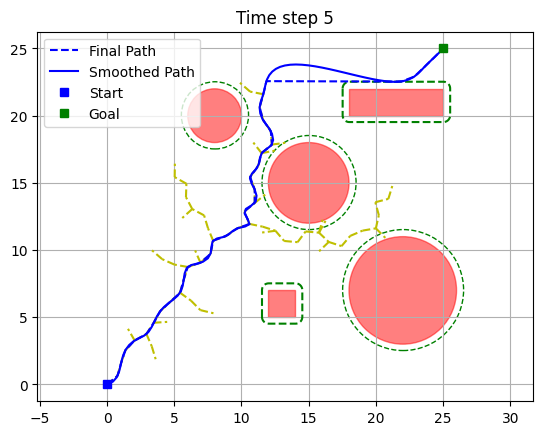

Time step: 6
Path distance: 42.54 units


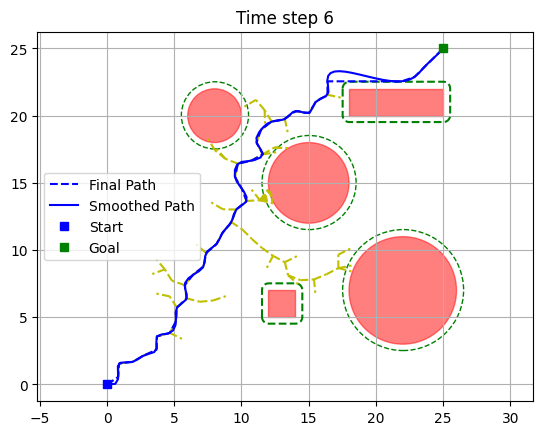

Time step: 7
Path distance: 41.66 units


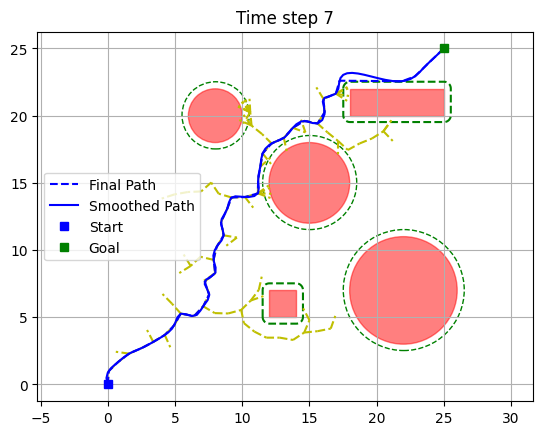

Time step: 8
Path distance: 44.77 units


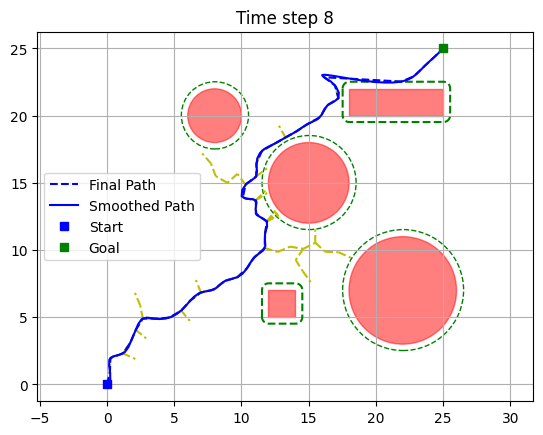

Time step: 9
Path distance: 49.22 units


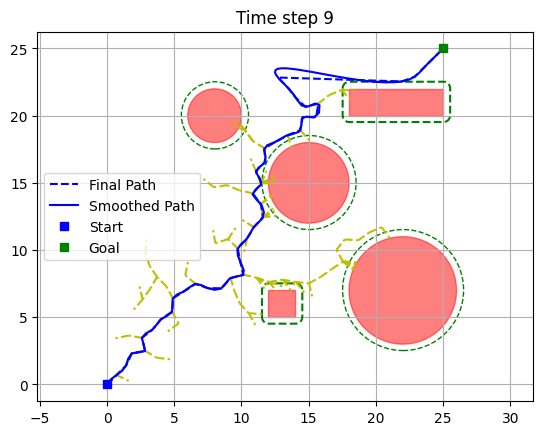

Time step: 10
Path distance: 44.21 units


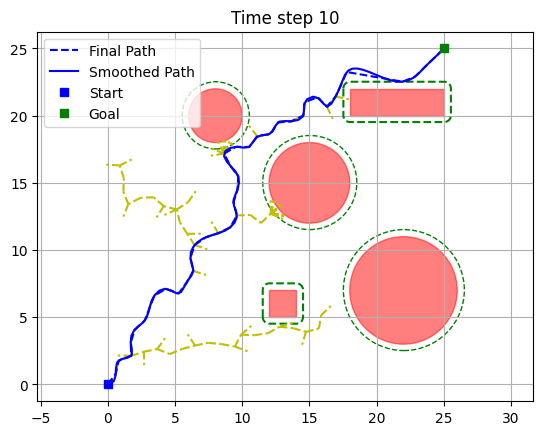

Time step: 11
Path distance: 44.20 units


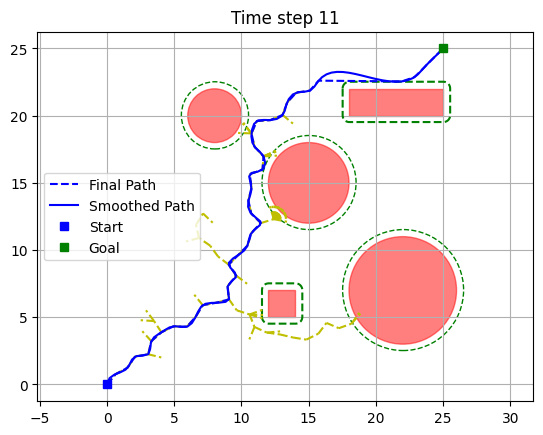

Time step: 12
Path distance: 47.21 units


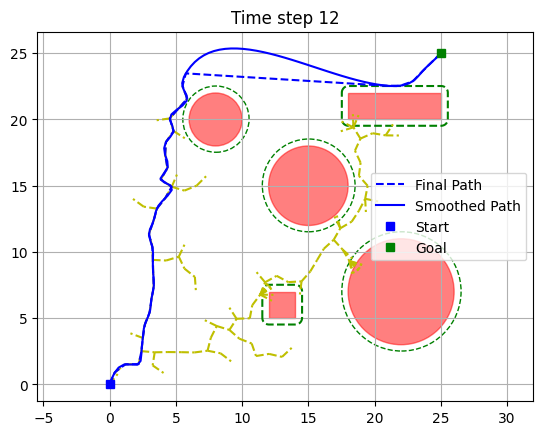

Time step: 13
Path distance: 44.98 units


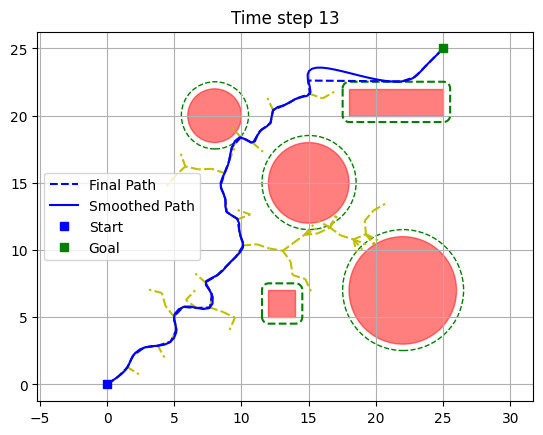

Time step: 14
Path distance: 49.35 units


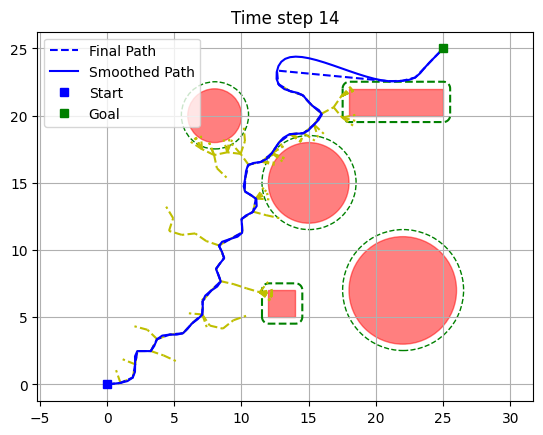

Time step: 15
Path distance: 47.00 units


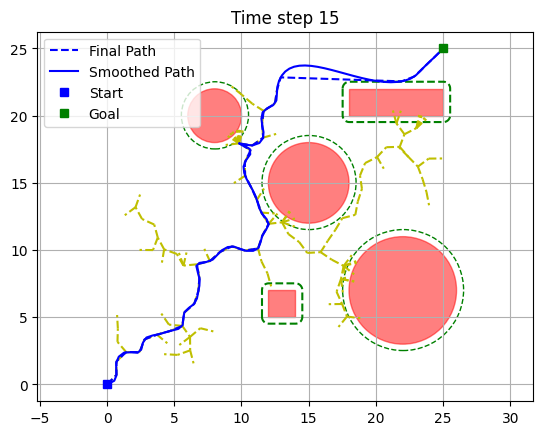

Time step: 16
Path distance: 45.98 units


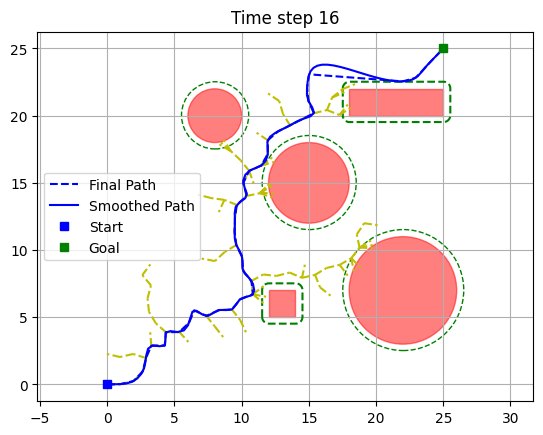

Time step: 17
Path distance: 45.72 units


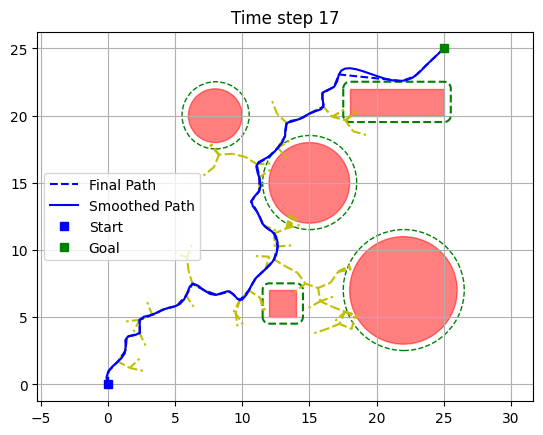

Time step: 18
Path distance: 49.58 units


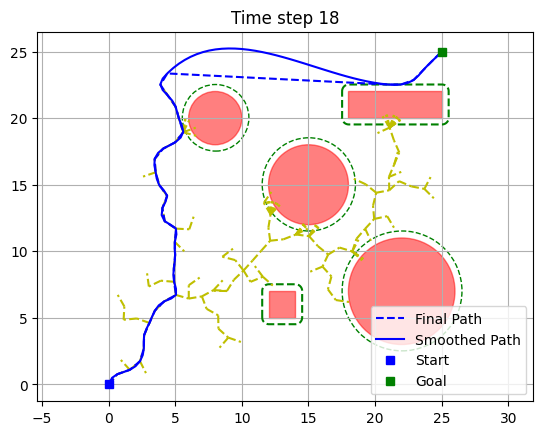

Time step: 19
Path distance: 46.85 units


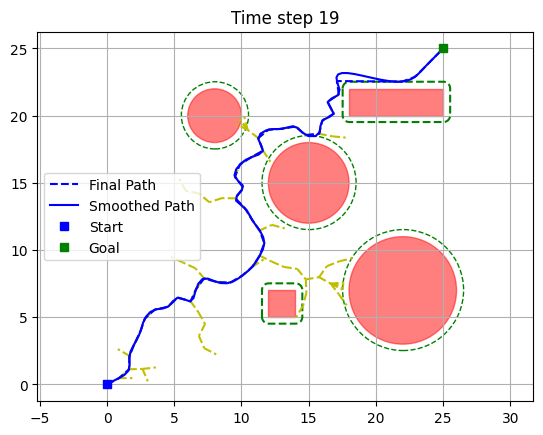

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from shapely.geometry import Point, Polygon, LineString
from scipy.interpolate import splev, splprep

# Collision detection function
def is_collision_free(start, end, obstacles):
    line = LineString([start, end])
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            ox, oy, radius = obstacle
            if line.distance(Point(ox, oy)) <= radius:
                return False
        elif isinstance(obstacle, list):  # Polygon obstacle
            obstacle_polygon = Polygon(obstacle)
            if line.intersects(obstacle_polygon):
                return False
    return True

# Calculate total distance of a path
def calculate_path_distance(path):
    total_distance = 0.0
    if path is None:
        return float('inf')
    for i in range(1, len(path)):
        x1, y1 = path[i - 1]
        x2, y2 = path[i]
        total_distance += math.hypot(x2 - x1, y2 - y1)
    return total_distance

# Bi-RRT* algorithm implementation
def bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles):
    map_size_x, map_size_y = 30, 30
    max_iter = 1000
    step_size = 1.0
    goal_sample_rate = 5
    start_tree = [(start_x, start_y, None)]
    goal_tree = [(goal_x, goal_y, None)]
    path = None
    all_paths = []
    for i in range(max_iter):
        if random.randint(0, 100) > goal_sample_rate:
            rnd_x, rnd_y = random.uniform(0, map_size_x), random.uniform(0, map_size_y)
        else:
            rnd_x, rnd_y = goal_x, goal_y
        nearest_node_start = min(start_tree, key=lambda node: math.hypot(node[0] - rnd_x, node[1] - rnd_y))
        new_x_start, new_y_start = nearest_node_start[0], nearest_node_start[1]
        angle = math.atan2(rnd_y - nearest_node_start[1], rnd_x - nearest_node_start[0])
        new_x_start += step_size * math.cos(angle)
        new_y_start += step_size * math.sin(angle)
        new_node_start = (new_x_start, new_y_start, nearest_node_start)
        if is_collision_free((nearest_node_start[0], nearest_node_start[1]), (new_x_start, new_y_start), effective_obstacles):
            start_tree.append(new_node_start)
            nearest_node_goal = min(goal_tree, key=lambda node: math.hypot(node[0] - new_x_start, node[1] - new_y_start))
            angle = math.atan2(new_y_start - nearest_node_goal[1], new_x_start - nearest_node_goal[0])
            new_x_goal = nearest_node_goal[0] + step_size * math.cos(angle)
            new_y_goal = nearest_node_goal[1] + step_size * math.sin(angle)
            new_node_goal = (new_x_goal, new_y_goal, nearest_node_goal)
            if is_collision_free((nearest_node_goal[0], nearest_node_goal[1]), (new_x_goal, new_y_goal), effective_obstacles):
                goal_tree.append(new_node_goal)

                # Check if trees can be connected
                if is_collision_free((new_x_goal, new_y_goal), (new_x_start, new_y_start), effective_obstacles):
                    # Build path from start to goal
                    path = []
                    node = new_node_start
                    while node is not None:
                        path.append((node[0], node[1]))
                        node = node[2]
                    path.reverse()
                    node = new_node_goal[2]
                    while node is not None:
                        path.append((node[0], node[1]))
                        node = node[2]
                    break

        # Store the intermediate path for later plotting
        if new_node_start[2] is not None:
            all_paths.append((new_node_start, new_node_start[2]))

    return path, all_paths

# Smooth path using B-spline
def smooth_path_b_spline(path, smoothing_factor=0):
    if not path:
        return []
    x, y = zip(*path)
    tck, u = splprep([x, y], s=smoothing_factor, k=3)
    u_fine = np.linspace(0, 1, num=100)
    x_fine, y_fine = splev(u_fine, tck)
    return list(zip(x_fine, y_fine))

# Display results function
def display_results(obstacles, effective_obstacles, path, smooth_path, all_paths, distance, title):
    plt.figure()
    plt.title(f"{title}")
    print(f"Path distance: {distance:.2f} units")

    # Draw original obstacles
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='r', alpha=0.5)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  # Polygon obstacle
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.fill(x, y, color='r', alpha=0.5)

    # Draw effective boundaries as dotted lines
    for obstacle in effective_obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
            ox, oy, radius = obstacle
            circle = plt.Circle((ox, oy), radius, color='g', linestyle='--', fill=False)
            plt.gca().add_patch(circle)
        elif isinstance(obstacle, list):  # Polygon obstacle
            obstacle_polygon = Polygon(obstacle)
            x, y = obstacle_polygon.exterior.xy
            plt.plot(x, y, 'g--')

    # Plot all intermediate paths
    for node, parent in all_paths:
        plt.plot([parent[0], node[0]], [parent[1], node[1]], 'y--')

    # Plot the final path
    if path:
        plt.plot([x for (x, y) in path], [y for (x, y) in path], 'b--', label='Final Path')

    # Plot the smoothed path
    if smooth_path:
        plt.plot([x for (x, y) in smooth_path], [y for (x, y) in smooth_path], 'b', label='Smoothed Path')
        
    plt.plot(start_x, start_y, "bs", label="Start")
    plt.plot(goal_x, goal_y, "gs", label="Goal")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()

# Dynamic obstacle movement
def move_obstacles(obstacles, velocity_x, velocity_y, time_step):
    moved_obstacles = []
    for obstacle in obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circular obstacle
            ox, oy, radius = obstacle
            new_ox = ox + velocity_x * time_step
            new_oy = oy + velocity_y * time_step
            moved_obstacles.append((new_ox, new_oy, radius))
        elif isinstance(obstacle, list):  # Polygon obstacle
            moved_obstacles.append([(x + velocity_x * time_step, y + velocity_y * time_step) for x, y in obstacle])
    return moved_obstacles

# Initial parameters
start_x, start_y = 0, 0
goal_x, goal_y = 25, 25
bonus_boundary = 0.5
velocity_x, velocity_y = 0.05, 0.05  # Movement speed of obstacles
time_step = 0.5  # Time step for obstacle movement

# Obstacles definition
original_obstacles = [
    (8, 20, 2),   # Circle obstacle with center (8, 20) and radius 2
    (22, 7, 4),   # Circle obstacle with center (22, 7) and radius 4
    (15, 15, 3),  # Circle obstacle with center (15, 15) and radius 3
    [(18, 22), (25, 22), (25, 20), (18, 20)],  # Rectangle obstacle
    [(12, 5), (14, 5), (14, 7), (12, 7)]       # Rectangle obstacle
]

# Simulation loop for dynamic obstacles
for t in range(20):  # Simulate for 20 time steps
    print(f"Time step: {t}")
    # Move obstacles
    moved_obstacles = move_obstacles(original_obstacles, velocity_x, velocity_y, time_step)
    
    # Create effective obstacles with boundaries
    effective_obstacles = []
    for obstacle in moved_obstacles:
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circular obstacle
            ox, oy, radius = obstacle
            effective_obstacles.append((ox, oy, radius + bonus_boundary))
        elif isinstance(obstacle, list):  # Polygon obstacle
            effective_obstacles.append(Polygon(obstacle).buffer(bonus_boundary).exterior.coords[:-1])

    # Run Bi-RRT* and get the path
    path, all_paths = bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles)
    
    # Smooth the path
    smooth_path = smooth_path_b_spline(path)
    
    # Calculate path distance
    distance = calculate_path_distance(path)
    
    # Display results
    display_results(original_obstacles, effective_obstacles, path, smooth_path, all_paths, distance, f"Time step {t}")
    plt.show()

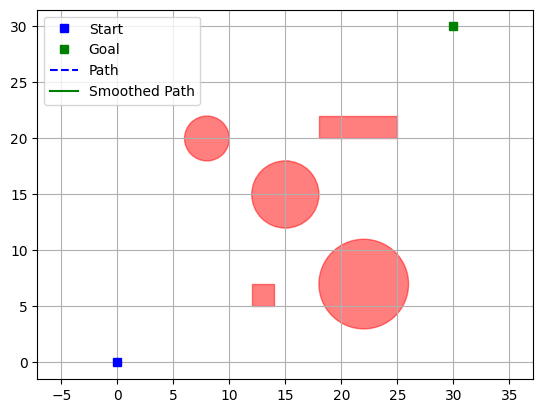

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from shapely.geometry import Point, Polygon, LineString

# Re-use the Bi-RRT*, collision detection, and obstacle adding functions

def update_plot(frame, scatters, obstacles, velocity_x, velocity_y, bonus_boundary, path_line, smooth_line):
    # Move obstacles by adding velocity
    for i, obstacle in enumerate(obstacles):
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circular obstacles
            ox, oy, radius = obstacle
            ox += velocity_x[i]  # Update X
            oy += velocity_y[i]  # Update Y
            obstacles[i] = (ox, oy, radius)
        elif isinstance(obstacle, list):  # Polygon obstacles
            shifted_polygon = [(x + velocity_x[i], y + velocity_y[i]) for (x, y) in obstacle]
            obstacles[i] = shifted_polygon

    # Recompute path dynamically
    effective_obstacles = add_bonus_boundary(obstacles, bonus_boundary)
    path, all_paths = bi_rrt_star(start_x, start_y, goal_x, goal_y, effective_obstacles)
    smooth_path = smooth_path_b_spline(path)

    # Update obstacle locations
    for i, obstacle in enumerate(obstacles):
        if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circular obstacle
            ox, oy, radius = obstacle
            scatters[i].center = (ox, oy)
        elif isinstance(obstacle, list):  # Polygon obstacle
            scatters[i].set_xy(obstacle)

    # Update path line
    if path:
        path_x = [x for (x, y) in path]
        path_y = [y for (x, y) in path]
        path_line.set_data(path_x, path_y)

    # Update smoothed path line
    if smooth_path:
        smooth_x = [x for (x, y) in smooth_path]
        smooth_y = [y for (x, y) in smooth_path]
        smooth_line.set_data(smooth_x, smooth_y)

    return scatters + [path_line, smooth_line]

# Initial parameters
start_x, start_y = 0, 0
goal_x, goal_y = 30, 30
bonus_boundary = 0.5
velocity_x = [0.1, 0.2, -0.1, 0.05]  # Example velocities for obstacles
velocity_y = [0.2, -0.1, 0.05, -0.2]

# Define original obstacles
obstacles = [
    (8, 20, 2),   # Circular obstacle
    (22, 7, 4),   # Circular obstacle
    (15, 15, 3),  # Circular obstacle
    [(18, 22), (25, 22), (25, 20), (18, 20)],  # Rectangular obstacle
    [(12, 5), (14, 5), (14, 7), (12, 7)]       # Rectangular obstacle
]

# Create plot and initial scatter for obstacles
fig, ax = plt.subplots()
scatters = []

# Plot static elements
ax.plot(start_x, start_y, "bs", label="Start")
ax.plot(goal_x, goal_y, "gs", label="Goal")

# Add circular and polygon obstacles to the scatter list
for obstacle in obstacles:
    if isinstance(obstacle, tuple) and len(obstacle) == 3:  # Circle obstacle
        ox, oy, radius = obstacle
        circle = plt.Circle((ox, oy), radius, color='r', alpha=0.5)
        ax.add_patch(circle)
        scatters.append(circle)
    elif isinstance(obstacle, list):  # Polygon obstacle
        obstacle_polygon = Polygon(obstacle)
        x, y = obstacle_polygon.exterior.xy
        poly = plt.Polygon(obstacle, color='r', alpha=0.5)
        ax.add_patch(poly)
        scatters.append(poly)

# Set up line for path and smooth path
path_line, = ax.plot([], [], 'b--', label='Path')
smooth_line, = ax.plot([], [], 'g-', label='Smoothed Path')

# Configure plot
plt.grid(True)
plt.axis("equal")
plt.legend()

# Create animation
ani = FuncAnimation(fig, update_plot, frames=100, fargs=(scatters, obstacles, velocity_x, velocity_y, bonus_boundary, path_line, smooth_line), interval=200)

plt.show()